In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.dirname(os.path.abspath("")))

from basslv import BassLocalVolatility, VanillaCall, VanillaPut, MarketMarginal
from basslv import HestonPricingEngine

In [2]:
tenors = [1., 2.]
forward = 1.
discountFactor = 1
strikes = np.linspace(0.25, 3., 200, endpoint=True)
callStrikes = strikes[np.where(strikes >= 1.)[0]]
putStrikes = strikes[np.where(strikes < 1.)[0]]

calls = [
    VanillaCall(
        forward=forward,
        discountFactor=discountFactor,
        timeToExpiry=tenor,
        pricingEngine=HestonPricingEngine(
            kappa=2.,
            theta=0.1,
            rho=-0.2,
            volOfVol=0.7,
            initialVariance=0.1
        )
    )
    for tenor in tenors
]

puts = [
    VanillaPut(
        forward=forward,
        discountFactor=discountFactor,
        timeToExpiry=tenor,
        pricingEngine=HestonPricingEngine(
            kappa=2.,
            theta=0.1,
            rho=-0.2,
            volOfVol=0.7,
            initialVariance=0.1
        )
    )
    for tenor in tenors
]

callPrices = [
    [
        call.NPV(strike=strike, volatility=None)
        for strike in strikes
    ]
    for call in calls
]

volatilitySmileTarget = [
    [
        call.getImpliedVolatility(
            strike=strikes[strikeIndex],
            optionPrice=callPrices[callIndex][strikeIndex]
        )
        for strikeIndex in range(len(strikes))
    ]
    for callIndex, call in enumerate(calls)
][0]

print(volatilitySmileTarget[:5])

[0.45830559932474085, 0.45241832839227375, 0.4467601695405452, 0.44131071198567434, 0.4360523599098378]


Converge error: current tol: 0.0001, reach 0.0014926279317658553
Error in zero: 0.125569265955786 for marginal.tenor=1.0
adjusted error in zero: -1.7963408538435033e-13



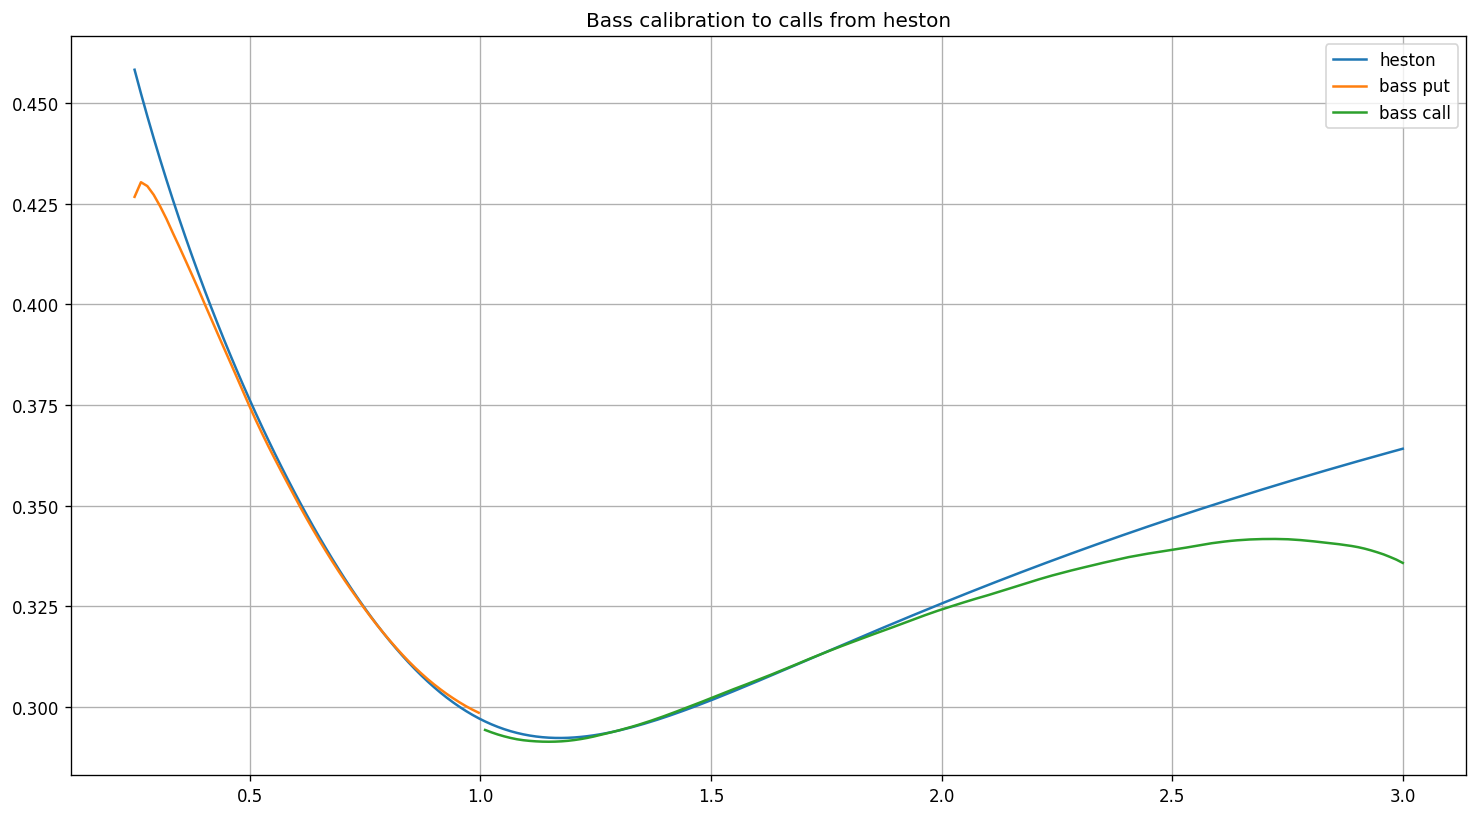

In [3]:
timeGridPoints = 3
pathsNumber = 100000
SEED = 42
t = np.linspace(0, tenors[-1], timeGridPoints, endpoint=True)

bassLocalVolatility = BassLocalVolatility()

marginals = [
    MarketMarginal(
        strikes=strikes,
        callPrices=callPrices[tenorIndex],
        tenor=tenors[tenorIndex]
    )
    for tenorIndex in range(len(tenors))
]

pathsBassLv = bassLocalVolatility.sample(
    t=t,
    pathsNumber=pathsNumber,
    marginals=marginals,
    randomGenerator=np.random.default_rng(SEED),
    fixedPointEquationTolerance=1e-4,
    fixedPointEquationMaxIter=61
)

bassCallPrices = np.mean(np.maximum(pathsBassLv[:, 1][None] - strikes[None].T, 0), 1)
bassCalls = np.mean(np.maximum(pathsBassLv[:, 1][None] - callStrikes[None].T, 0), 1)
bassPuts = np.mean(np.maximum(putStrikes[None].T - pathsBassLv[:, 1][None], 0), 1)
absError = np.abs(bassCallPrices - np.array(callPrices[0]))
relativeError = np.abs(bassCallPrices - np.array(callPrices[0])) / np.array(callPrices[0])

volatilityCallSmileBass = [
    calls[0].getImpliedVolatility(
        strike=callStrikes[strikeIndex],
        optionPrice=bassCalls[strikeIndex]
    )
    for strikeIndex in range(len(callStrikes))
]

volatilityPutSmileBass = [
    puts[0].getImpliedVolatility(
        strike=putStrikes[strikeIndex],
        optionPrice=bassPuts[strikeIndex]
    )
    for strikeIndex in range(len(putStrikes))
]



_, axis = plt.subplots(figsize=(15, 8), dpi=120)

axis.plot(strikes, volatilitySmileTarget, label='heston')
axis.plot(putStrikes.tolist(), volatilityPutSmileBass, label='bass put')
axis.plot(callStrikes.tolist(), volatilityCallSmileBass, label='bass call')

axis.set_title("Bass calibration to calls from heston")
axis.legend()
axis.grid(True)
plt.show()